В своей знаменитой статье [l-1 trend filtering](https://web.stanford.edu/~boyd/papers/l1_trend_filter.html) Стивен Бойд и его коллеги предложили подход к выявлению тренда в финансовых временных рядах с помощью выпуклой оптимизации. В частности, вместо построения стохастической модели временного ряда, они предложили отталкиваться от задачи - построить кусочно-линейную линию тренда, наилучшим образом аппроксимирующую данный временной ряд.

Это привело к задачи оптимизации следующего вида:

**TrendFilter problem**
$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
где $y \in R^T$ - временной ряд фактических цен акции (с момента времени $t = 1$ до момента времени $T$), матрица $D \in R^{(T-2) \times T}$ является трехдиагональной: $[Dx]_i = x_i - 2 \cdot x_{i+1} + x_{i+2} \quad$ ($1\leq i \leq T-2$).

Первый член в целевой функции отвечает за близость решения к фактическим данным, а второй форсирует решение  быть кусочно-линейной функцией с минимальным числом "изломов". 

Задачи проекта:
1. Выписать двойственную задачу для задачи Trend Filter.
2. Численно решите задачу Trend Filter используя одну из версий проксимального градиентного спуска, скачав тестовые данные: данные о цене закрытия акций российских финансовых компаний.
3. Выписать сглаженную версию задачи Trend Filter и найти ее решение используя метод быстрого градиентного спуска.
4. Выписать схему ADMM для решения задачи Trend Filter, реализовать ее и найти численное решение задачи. 
5. Сравнить полученные результаты на тестовых данных.

In [ ]:
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from tqdm import tqdm

# 1. Загрузка данных

Скачаем данные акций Apple с апреля 2021 по апрель 2022 с интервалом 1 час.

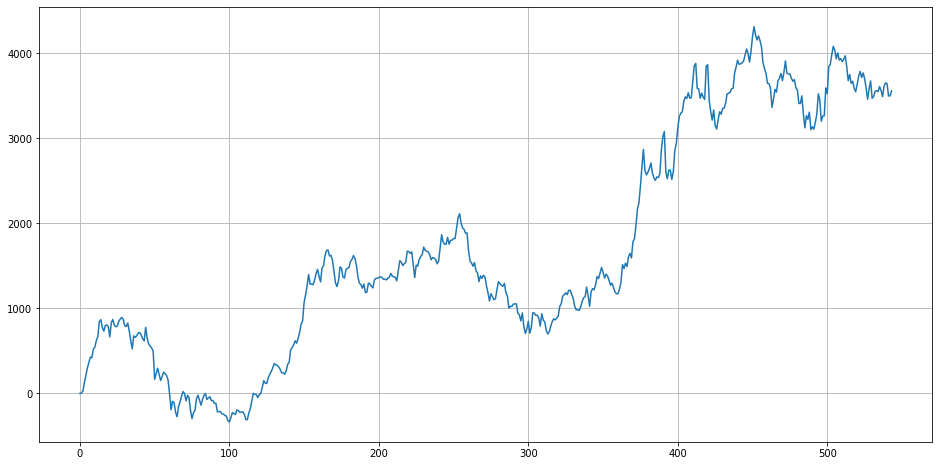

In [ ]:
file = pd.read_csv("Apple.txt", sep=",")
initial = np.array(file.loc[:, "<CLOSE>"])
data = []
for i in range(len(initial) // 6): #уменьшаем количество значений в 6 раз, ищем на каждом интервале [6i, 6(i+1)] разбиения среднее
    data.append(initial[6 * i : 6* (i + 1)].mean()) 
data -= data[0]
plt.figure(figsize=(16,8))
plt.plot(data)
plt.grid()

# 2. Двойственная задача

$$
\min_{x \in R^T} \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1
$$
Сделаем замену переменных 
$$z = Dx$$ 
Тогда наша задача теперь выглядит так:
$$
\min_{x \in R^T, z = Dx} \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1
$$
Построим Лагранжиан:
$$
L(x, z, \mu) = \frac{1}{2}\|y - x\|_2^2 + \lambda \|z\|_1 + \mu^T(Dx - z)
$$
Двойственная функция: 
$$
g(\mu) = inf_{x, z} L(x, z, \mu)
$$
Т.к $f(x) = \frac{1}{2}\|y - x\|_2^2 + \lambda \|Dx\|_1$ - выпукла, a $z - Dx$ - аффинна, то у нас задача выпуклого программирования, значит $\nabla L(x, z, \mu) = 0$ - является достаточным.
$$
<\nabla_{x} L(x, z, \mu), dx> = \frac{1}{2}(<d(x - y), x - y> + <x - y, d(x - y)>) + <\mu, d(Dx - z)>
$$
$$
<\nabla_{x} L(x, z, \mu), dx> = <x - y, dx> + <D^T\mu, dx>
$$
$$
\nabla_{x} L(x, z, \mu)> = x - y + D^T\mu = 0 \Leftrightarrow x^* = y - D^T\mu
$$
$$
\nabla_{z} L(x, z, \mu) : 0 \in (\lambda \partial \|z_i\|_1 + \mu_i)
$$
$$\partial \|z_i\|_1 = \begin{cases}
                          -1,\  & z_i < 0, \\
                          1, \  & z_i > 0, \\
                          [-1,1],\ & z_i = 0.
                      \end{cases}
$$
$$\lambda \partial \|z_i\|_1 + \mu_i = \begin{cases}
                          -\lambda + \mu_i,\  & z_i < 0, \\
                          \lambda + \mu_i, \  & z_i > 0, \\
                          [\mu_i-\lambda,\mu_i + \lambda],\ & z_i = 0.
                      \end{cases}
$$
$$0 \in (\lambda \partial \|z_i\|_1 + \mu_i) \Rightarrow \begin{cases}
                          \lambda = \mu_i,\  & z_i < 0, \\
                          \lambda = -\mu_i, \  & z_i > 0, \\
                          0 \in [\mu_i-\lambda,\mu_i + \lambda] \Rightarrow -\lambda <= \mu_i <= \lambda,\ & z_i = 0.
                      \end{cases}
$$
Заметим, что взяв $z_i > 0$ и $\lambda = -\mu_i$ у нас сократится $\lambda \|z_i\|_1 + \mu_iz_i$. Аналогично если взять $z_i < 0$ и $z_i = 0$. Значит наша двойственная функция имеет следующий вид:
$$
g(\mu) = \frac{1}{2}\|D^T\mu\|_2^2 - \mu^T(D(y - D^T\mu)) = -\frac{1}{2}\mu^TDD^T\mu + \mu^TDy
$$
Dual problem:
$$
\max_{-\lambda \preceq \mu \preceq \lambda} -\frac{1}{2}\mu^TDD^T\mu + \mu^TDy
$$

# 3. Проксимальный градиентный спуск

$f(x) = \frac{1}{2}\|y-x\|_2^2 + \lambda \|Dx\|_1$

Т.к матрица трёхдиагональная, то численно найти argmin от $h(z) = Dz$ - выпуклой и негладкой функции будет сложно, т.к её i-я строка задана рекуррентно. Сделаем замену так, чтобы превратить $\|Dx\|_1 \rightarrow \sum\limits_{i = 3} |\xi_i|$. Пусть $\xi = (x_1, x_2 - x_1, (Dx)^T)^T$

$$x = A\xi$$
Тогда:
$x_1 = a_{11} * \xi_1 \Rightarrow a_{11} = 1$, $x_2 = a_{21} * \xi_1 + a_{22}*\xi_2 \Rightarrow a_{21} = 1, a_{22} = 1$,

$x_3 = a_{31} * \xi_1 + a_{32}*\xi_2 + a_{33}*\xi_3 \Rightarrow x_3 = a_{31} * x_1 + a_{32}* (x_2 - x_1) + a_{33}* (x_1 - 2x_2 + x_3) \Rightarrow a_{31} = 1, a_{32} = 2, a_{33} = 1$ и т.д. Значит матрица A имеет вид:
$$
A = \begin{pmatrix}
1  \\
1 & 1 \\
1 & 2 & 1 \\
1 & 3 & 2 & 1 \\
... \\
1 & n-1 & n-2 & ... & 2 & 1 
\end{pmatrix}$$

Значит теперь наша функция имеет вид:
$$f(\xi) = \frac{1}{2}\|A\xi - y\|_2^2 + \lambda \sum\limits_{i=3}^{n} |\xi_i|$$
Тогда $g(\xi) = \frac{1}{2}\|A\xi - y\|_2^2$ - выпуклая и гладкая, а $h(\xi) = \lambda \sum\limits_{i=3}^{n} |\xi_i|$ - выпуклая и негладкая. 
Воспользуемся алгоритмом проксимального градиентного спуска:
$$f(\xi,z) = g(\xi)  +  <\nabla g(\xi), z - \xi> + \frac{\nu}{2}\|z - \xi\|_2^2 + h(z) \Rightarrow f(\xi,z) = f(\xi) \Leftrightarrow z = \xi$$
$$\xi_{k+1} = argmin_{z} f(\xi_k, z) = argmin_{z}(<\nabla g(\xi_k) + \frac{\nu}{2}(z - \xi_k), z - \xi_k> + h(z))$$
$$\xi_{k+1} = argmin_{z}(\frac{\nu}{2}<\frac{1}{\nu}\nabla g(\xi_k) + z - \xi_k, z - \xi_k> + <\frac{1}{\nu}\nabla g(\xi_k), z - \xi_k +  \frac{1}{\nu}\nabla g(\xi_k) - \frac{1}{\nu}\nabla g(\xi_k)> + h(z))$$
$$\xi_{k+1} = argmin_{z}(\frac{\nu}{2}\|\frac{1}{\nu}\nabla g(\xi_k) + z - \xi_k\|_2^2 - \|\frac{1}{\nu}\nabla g(\xi_k)\|_2^2 + h(z))$$
$$\xi_{k+1} = argmin_{z}(\frac{\nu}{2}\|\frac{1}{\nu}\nabla g(\xi_k) + z - \xi_k\|_2^2 + h(z)) = prox_{h, \nu}(\xi_k - \frac{1}{\nu}\nabla g(\xi_k))$$
$$prox_{h, \nu}(m) = argmin_{z}(\frac{\nu}{2}\|z - m\|_2^2 + \lambda \sum\limits_{i=3}^{n} |z_i|)$$
$$\begin{cases}
               i < 3 \Rightarrow (z_i - m_i) = 0 \Rightarrow z_i = m_i \\
               i \geqslant 3 \Rightarrow 0 \in (\nu(z_i - m_i) + \lambda\partial|z_i|)
\end{cases}
$$
Значит, при $i \geqslant 3$
$$
\begin{cases}
               z_i = m_i - \frac{\lambda}{\nu}  & m_i > \frac{\lambda}{\nu} ,\\
               z_i = m_i + \frac{\lambda}{\nu}  & m_i < -\frac{\lambda}{\nu} ,\\
               z_i = 0 & |m_i| \leqslant \frac{\lambda}{\nu}.
\end{cases}
$$
Осталось посчитать градиент $g(\xi)$:
$$
<\nabla g(\xi), dx> =  \frac{1}{2}(<A\xi - y, A d\xi> + <A d\xi, A\xi - y> \Rightarrow \nabla g(\xi) = A^T(A\xi - y)
$$

In [ ]:
n = len(data)
A = np.eye(n)
for i in range(n):
    A[i][0] = 1
    for j in range(1, i):
        A[i][j] = i - j + 1
A

array([[  1.,   0.,   0., ...,   0.,   0.,   0.],
       [  1.,   1.,   0., ...,   0.,   0.,   0.],
       [  1.,   2.,   1., ...,   0.,   0.,   0.],
       ...,
       [  1., 541., 540., ...,   1.,   0.,   0.],
       [  1., 542., 541., ...,   2.,   1.,   0.],
       [  1., 543., 542., ...,   3.,   2.,   1.]])

In [ ]:
data = np.array(data)
y = data[:, np.newaxis] #переделываем строку в вектор-столбец
v = 1e10
la = 5e-6
def prox(x):
    gradient = A.T @ (A @ x - y)
    x_new = x - gradient/v
    for i in range(3, n):
        if x_new[i][0] > la/v:
            x_new[i][0] -= la/v
        elif x_new[i][0] < -la/v:
            x_new[i][0] += la/v
        else:
            x_new[i][0] = 0
    return x_new

In [ ]:
Ksi = np.zeros((n, 1))
steps = 200000
for step in tqdm(range(steps)):
    Ksi = prox(Ksi)

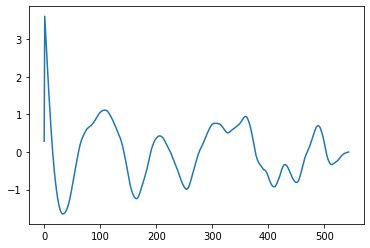

In [ ]:
plt.plot(Ksi)

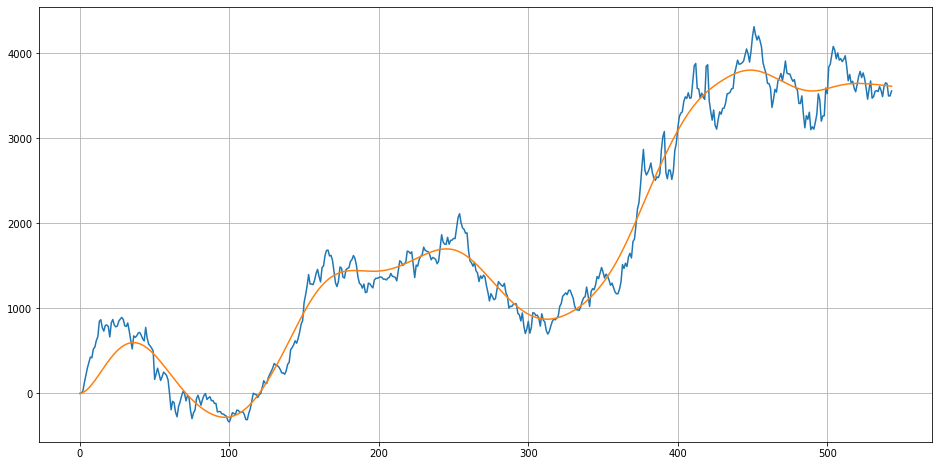

In [ ]:
X = A @ Ksi
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(X)
plt.grid()

# 4. Smoothing and Fast Gradient Descent

Рассмотрим технику сглаживания:
$$f(x) \rightarrow \min\limits_{x \in Q_1}$$
$$f(x) = \max\limits_{u \in Q_2} (u^TAx -\varphi_2(u)) + \varphi_1(x)$$
Где $\varphi_2(u)$ и $\varphi_1(x)$ - гладкие и выпуклые функции, а $\max\limits_{u \in Q_2} (u^TAx -\varphi_2(u))$ - явно не гладкая.

Рассмотрим такую функцию $d(u)$ - ($\theta$ - сильно выпуклую) и равную нулю в своей оптимальной точке. Тогда нашу функцию $f(x)$ мы будем приближать гладкой функцией $f_{\mu}(x) = \max\limits_{u \in Q_2} (u^TAx -\varphi_2(u) - \mu d(u)) + \varphi_1(x)$. Значит теперь мы работаем с функцией $f_{\mu}(x)$:
$$f_{\mu}(x) \rightarrow \min\limits_{x \in Q_1}$$
$$f_{\mu}(x) \leqslant f(x) \leqslant f_{\mu}(x) + \mu \max\limits_{u \in Q_2} d(u)$$
Теперь перепишем нашу задачу, пригодную для сглаживания: $\varphi_1(x) = \frac{1}{2}\|y - x\|_2^2$, $\varphi_2(u) = 0$, $Ax = Dx$. Значит, чтобы получить сумму норм, нужно максимизировать по области: $Q_2 = \{u | |u| \leqslant 1\}$
$$f(x) = \frac{1}{2}\|y - x\|_2^2 + \lambda \max\limits_{|u| \leqslant 1} (u^TDx)$$
На семинаре говорили, что можно спокойно выбирать вторую норму в качестве функции $d(u)$ $\Rightarrow$ возьмём $d(u) = \|u\|_2^2$. Значит $\max\limits_{|u| \leqslant 1} d(u) = \sum\limits_{1}^{n-2} (1^2) = n-2$. Получим функцию $f_\mu (x)$:
$$f_\mu (x) = \max\limits_{|u| \leqslant 1}(u^TDx - \mu \|u\|_2^2) + \frac{1}{2}\|y - x\|_2^2$$
Найдём максимум:
$$u^TDx - \mu \|u\|_2^2 = \sum\limits_{i = 1}^{n-2} (u_i (Dx)_i - \mu u_i^2) \Rightarrow u_i = \frac{(Dx)_i}{2\mu} \in [-1, 1]$$
$$u_i^* = \begin{cases}
               \frac{(Dx)_i}{2\mu}  & |(Dx)_i| \leqslant 2\mu ,\\
               1  & (Dx)_i > 2\mu ,\\
               -1 & (Dx)_i < -2\mu.
\end{cases}$$
К сожалению, я не нашёл быстрый градиентный спуск в лекции про сглаживание, поэтому я взял его с семинаров Катруци:
$$
\begin{cases}
y_{0} = x_{0}\\
x_{k+1} = y_{k} - \alpha_k \nabla f(y_k) \\
y_{k+1} = x_{k+1} + \frac{k}{k+3}(x_{k+1} - x_{k})
\end{cases}
$$
$$\nabla f_{\mu}(x) = (x-y) + \lambda D^Tu^*$$

In [ ]:
D = np.zeros((n-2, n)) #построим 
for i in range(n-2):
    D[i][i] = 1
    D[i][i+1] = -2
    D[i][i+2] = 1
D

array([[ 1., -2.,  1., ...,  0.,  0.,  0.],
       [ 0.,  1., -2., ...,  0.,  0.,  0.],
       [ 0.,  0.,  1., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  0.,  0.],
       [ 0.,  0.,  0., ..., -2.,  1.,  0.],
       [ 0.,  0.,  0., ...,  1., -2.,  1.]])

In [ ]:
L = 1e5
mu = 0.2
lam = 1e5
data = np.array(data)
y = data[:, np.newaxis]
def gradient(x):
    u = np.zeros((n-2, 1))
    result = D @ x
    for i in range(n-2):
        if result[i][0] > 2*mu:
            u[i][0] = 1
        elif result[i][0] < -2*mu:
            u[i][0] = -1
        else:
            u[i][0] = result[i][0] / (2*mu)
    return (x - y) + lam*D.T @ u 

In [ ]:
def Fast_Gradient_Descent(x, step):
    v = x
    x_new = v - gradient(v) / L
    v = x_new + (step)/(step + 3) * (x_new - x)
    return x_new

In [ ]:
x_1 = np.zeros((n, 1), dtype = float)
steps = 200000
for step in tqdm(range(steps)):
    x_1 = Fast_Gradient_Descent(x_1, step)

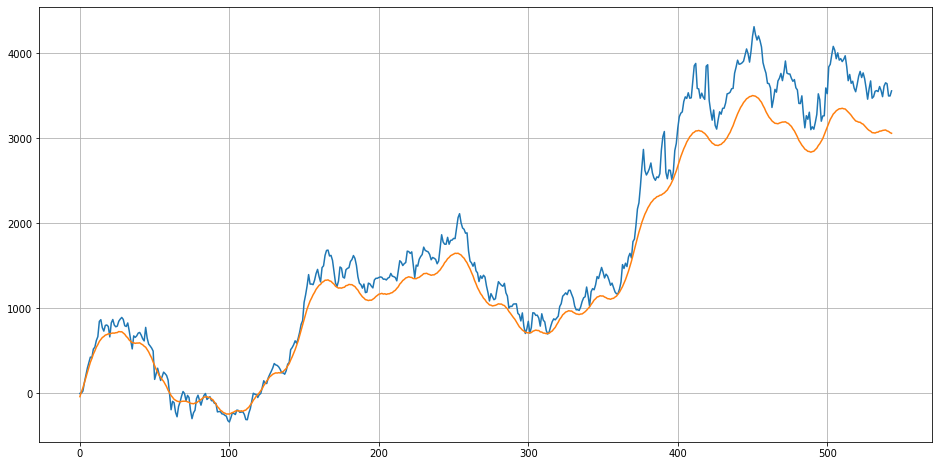

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(x_1)
plt.grid()

# 5.ADMM

Сделаем замену $z = Dx$

$$\min\limits_{Dx-z=0} \frac{1}{2} \|x-y\|_2^2 +\lambda \|z\|_1$$

$$f(x) = \frac{1}{2} \|x-y\|_2^2; g(z) = \lambda \|z\|_1$$
Метод модифицированной функции Лагранжа:
$$L_r(x, z, \mu) = \frac{1}{2} \|x-y\|_2^2 +\lambda \|z\|_1 + \mu^T(Dx-z) + \frac{r}{2}\|Dx-z\|_2^2$$
Правила обновления:
$$\mu_{k+1} = \mu_k + r(Dx-z)$$
Для $x_{k+1}$:
$$x_{k+1} = argmin_x L_r(x, z_k, \mu_{k+1}) \Rightarrow \nabla_x L_r(x, z_k, \mu_{k+1}) = (x-y) + D^T \mu + r D^T(Dx-z)=0$$
$$(I + r D^T D)x = y - D^T \mu + r D^T z$$
$$x_{k+1} = (I + r D^T D)^{-1} (y - D^T \mu_{k+1} + r D^T z_k)$$
Для $z_{k+1}$:
$$z_{k+1} = argmin_z L_r(x_{k+1}, z, \mu_{k+1}) \Rightarrow 0 \in \partial_z L_r(x_{k+1}, z, \mu_{k+1})$$ 
$$
z_i^{k+1} = \begin{cases}
  (Dx_{k+1} + \frac{\mu_{k+1}}{r})_i - \frac{\lambda}{r} & (Dx_{k+1} + \frac{\mu_{k+1}}{r})_i > \frac{\lambda}{r}\\
  (Dx_{k+1} + \frac{\mu_{k+1}}{r})_i + \frac{\lambda}{r} & (Dx_{k+1} + \frac{\mu_{k+1}}{r})_i < -\frac{\lambda}{r}\\
  0 & |(Dx_{k+1}+\frac{\mu_{k+1}}{r})_i| < \frac{\lambda}{r} 
 \end{cases}
$$  



In [ ]:
r = 1e4
I = np.eye(n)
la_2 = 3e4
def update(x, z, mu):
    mu = mu + r * (D @ x - z)
    x = np.linalg.inv(I + r*D.T @ D) @ (y - D.T @ (mu - r * z))
    z = D @ x + mu / r
    for i in range(n - 2):
        if z[i][0] > la_2 / r:
            z[i][0] -= la_2 / r
        elif z[i][0] < - la_2 / r:
            z[i][0] += la_2 / r
        else:
            z[i][0] = 0
    return x, z, mu

In [ ]:
mu_2 = np.zeros((n - 2, 1))
x_2 = np.zeros((n, 1))
z = np.zeros((n-2, 1))

In [ ]:
steps = 10000
for step in tqdm(range(steps)):
    x_2, z, mu_2 = update(x_2, z, mu_2)

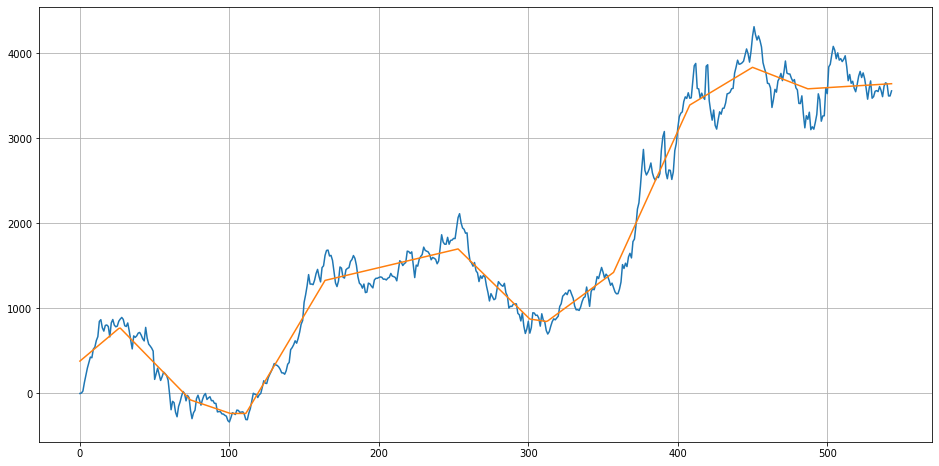

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data)
plt.plot(x_2)
plt.grid()

In [ ]:
Result_ADMM = x_2
Result_ADMM

#  6. Сравнение результатов

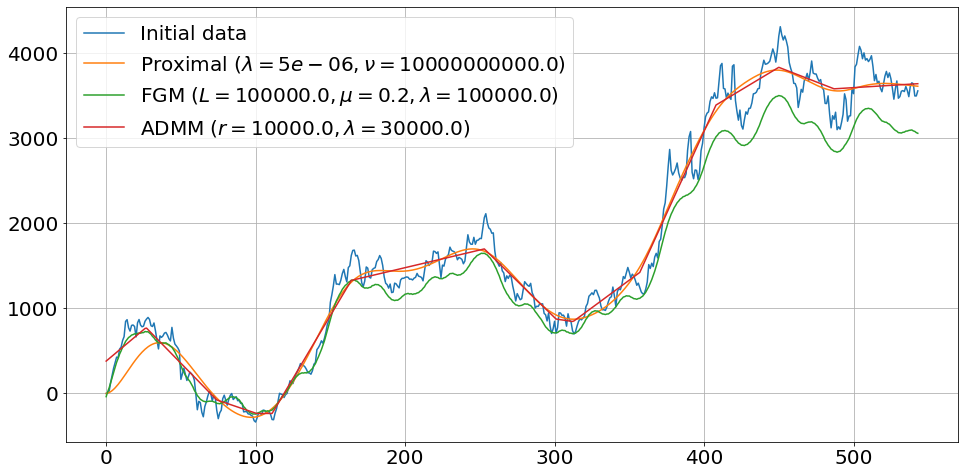

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(data, label="Initial data")
plt.plot(X, label=r"Proximal $(\lambda = {}, \nu = {})$".format(la, v))
plt.plot(x_1, label=r"FGM $(L = {}, \mu = {}, \lambda = {})$".format(L, mu, lam))
plt.plot(x_2, label=r"ADMM $(r = {}, \lambda = {})$".format(r, la_2))
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.legend(fontsize=20)
plt.grid(True)